# Estimation des paramètres

In [1]:
import pickle
import utilities
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import spacy
import re
import sklearn
import random
import textdistance

from spacy.vocab               import Vocab
from spacy.language            import Language
from spacy.tokens              import Token
from spacymoji                 import Emoji
from   sklearn.tree            import DecisionTreeClassifier
from   sklearn.model_selection import train_test_split
from sklearn                   import metrics
from sklearn.model_selection   import GridSearchCV
from sklearn.metrics           import confusion_matrix
from sklearn.metrics           import roc_curve


C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\a.tekiouk\AppData\Local\Programs\Py

In [2]:
nlp = spacy.load("en_core_web_sm")

@Language.component("hashtag")
def hashtag_pipe(
    doc: spacy.tokens.Doc
) -> spacy.tokens.Doc:
    """
    A spaCy pipeline component that merges tokens of the form #word into a single token.

    Parameters
    ----------
    doc : spacy.tokens.Doc
        The input spaCy Doc object to process.

    Returns
    -------
    spacy.tokens.Doc
        The processed spaCy Doc object with hashtags merged into a single token.
    """
    len_doc = -1
    for token in doc:
        len_doc=len_doc+1
    merged_hashtag = False
    while True:
        for token in doc:
            if token.text == '#':
                if(token.head is not None and token.i!=len_doc):
                    start_index = token.i
                    end_index = start_index + 1
                    with doc.retokenize() as retokenizer:
                        retokenizer.merge(doc[start_index:end_index+1])
                        merged_hashtag = True
                        break
        if not merged_hashtag:
            break
        merged_hashtag = False
    return doc

nlp.add_pipe("emoji", first=True)
nlp.add_pipe("hashtag", first=True)
Token.set_extension("is_hashtag", getter=lambda token: token.text[0] in ("#"), force=True)

Importation du corpus.

In [158]:
corpus = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/DATA/chanel10k.csv", sep=";", parse_dates=["publication_time"])

# on récupére les posts en anglais
mask = corpus["language"] == 'en'
corpus = corpus.loc[mask]
chanel = corpus['text'].tolist()
publication_time_chanel = corpus['publication_time'].tolist()

print(f"# documents in corpus: {len(chanel)}")

# documents in corpus: 1802


In [ ]:
pd.DataFrame(new_lines[0:110]).to_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/new_lines.csv")

### Estimation du seuil de la distance de Levenshtein normalisée

In [159]:
def get_nb_remaining_posts_per_thresholds(
    corpus   : pd.DataFrame,
    )-> tuple[list,list]:
    """
    Return the number of post after deleting the posts with similar text and all the threshholds tested.

    Parameters
    ----------
    corus   : pd.DataFrame
    """
    nb_remaing_posts = []
    thresholds = np.linspace(0,1,11)
    dist = textdistance.levenshtein.normalized_distance
    for threshold in thresholds:
        nb_remaing_posts.append(len(utilities.delete_duplicates(corpus['text'].tolist(),corpus['publication_time'].tolist(),threshold,dist)))
    return thresholds,nb_remaing_posts
        

In [160]:
def plot_n_curves_remaining_posts(
    n : int,
    sample_size : int,
    corpus : pd.DataFrame):
    for i in range(n):
        best_thresholds=[]
        sample = corpus[['text','publication_time']].sample(n= sample_size)
        x,y = get_nb_remaining_posts_per_thresholds(sample)
        y = [i*100/max(y) for i in y]
        fig = plt.figure()
        with plt.style.context('Solarize_Light2'):
            plt.plot(x, y)
            plt.grid(color='r',linewidth=0.25)
            plt.xlabel('Levenshtein thresholds',fontweight = 'bold')
            plt.ylabel('% of remaining posts',fontweight = 'bold')
            target_value = 95
            value_below_target = next((value for value in y if value < target_value), None)
            plt.figtext(0.2, 0.2, f'Best threshhold : {round(x[y.index(value_below_target)],1)}')
        best_thresholds.append(round(x[y.index(value_below_target)],1))
    return best_thresholds


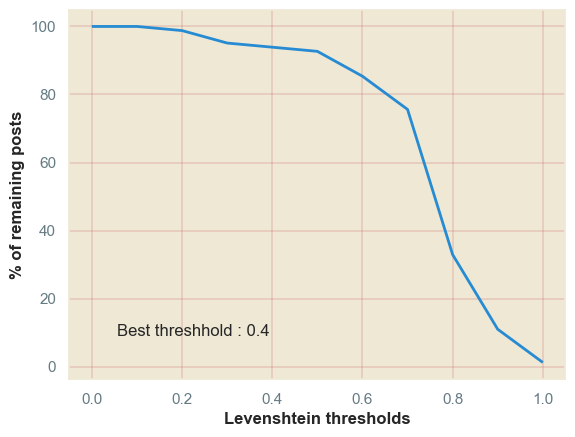

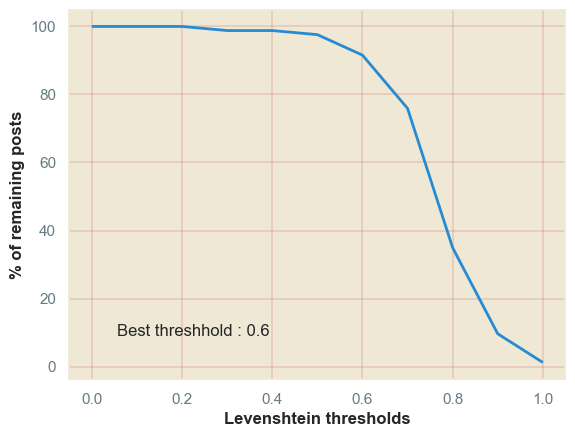

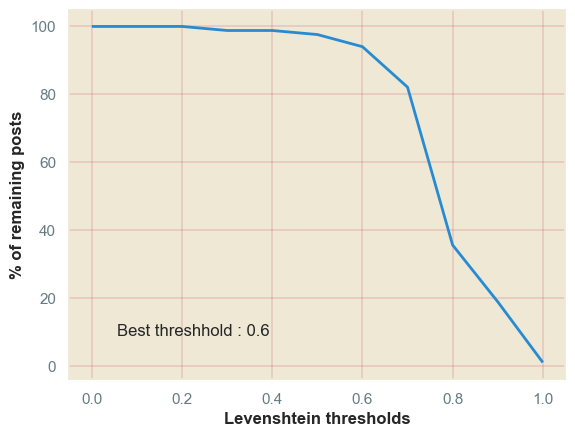

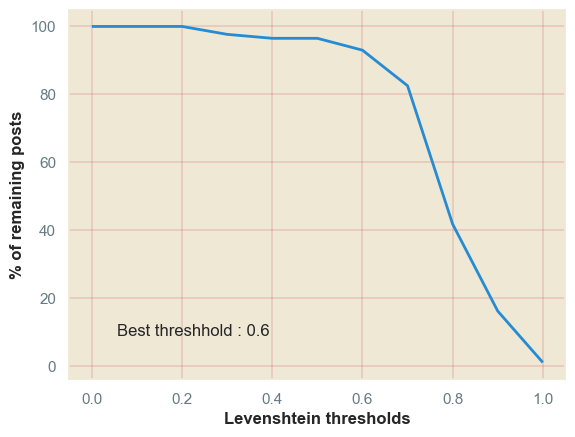

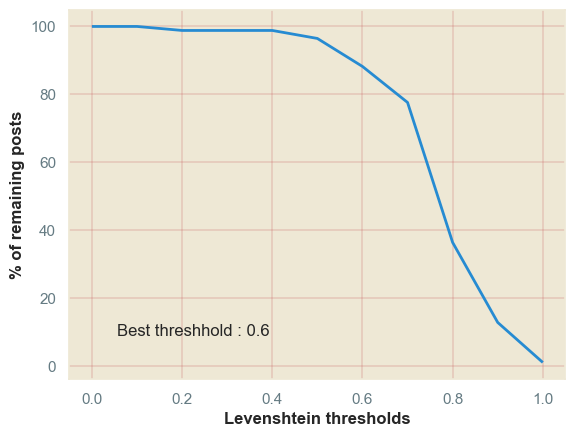

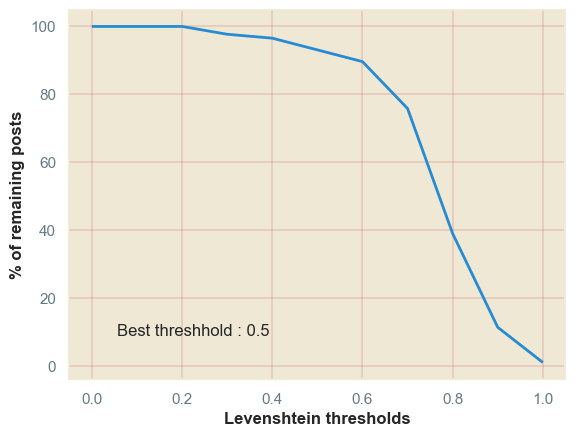

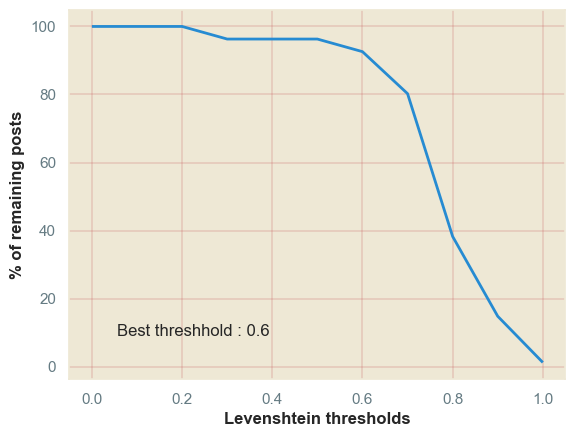

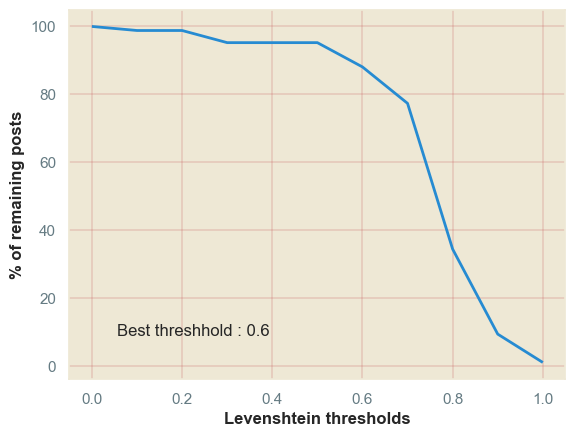

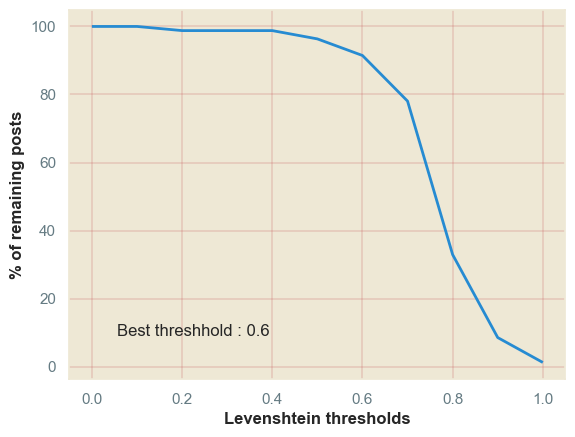

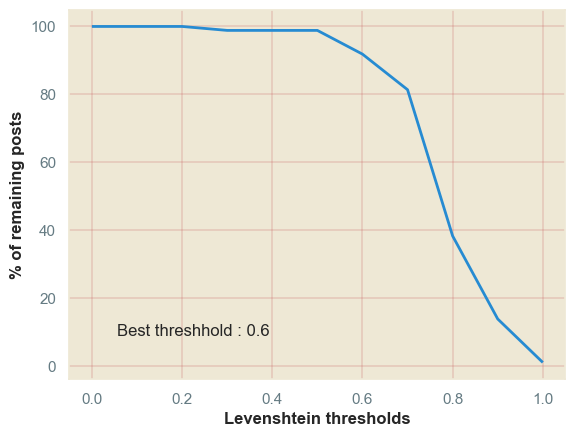

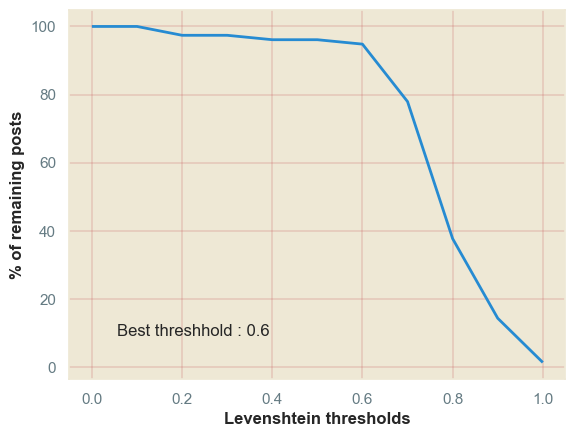

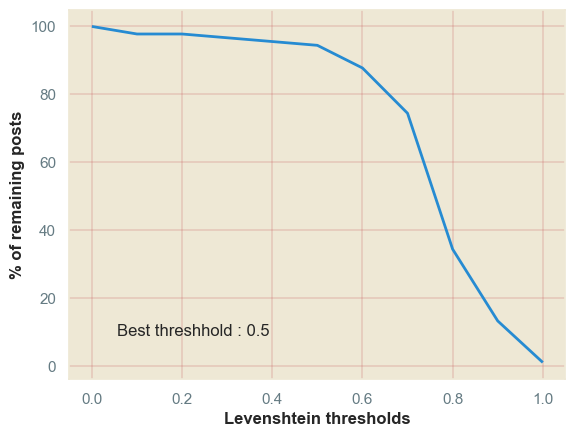

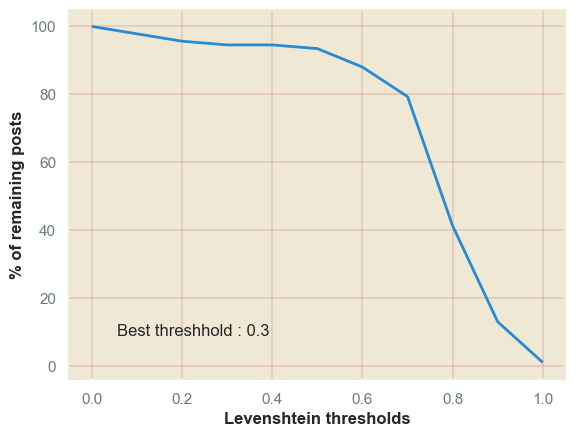

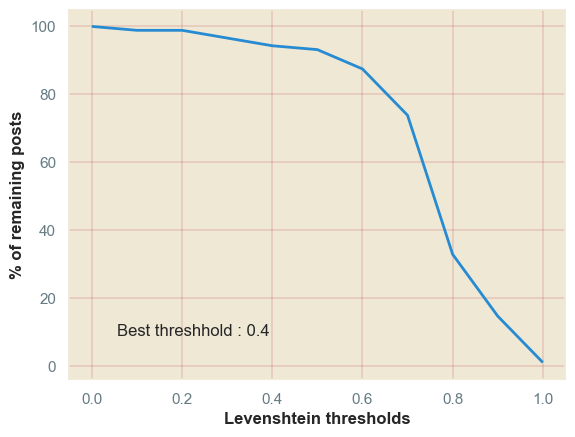

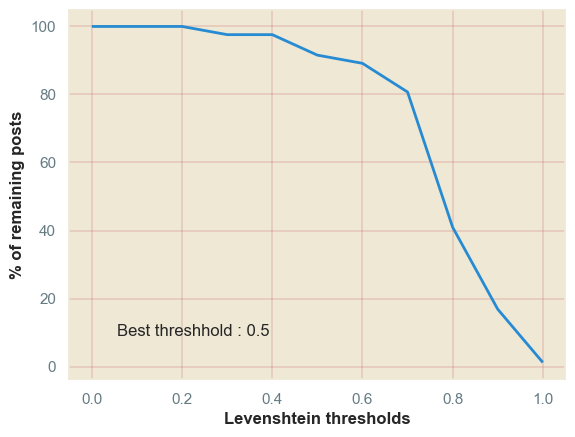

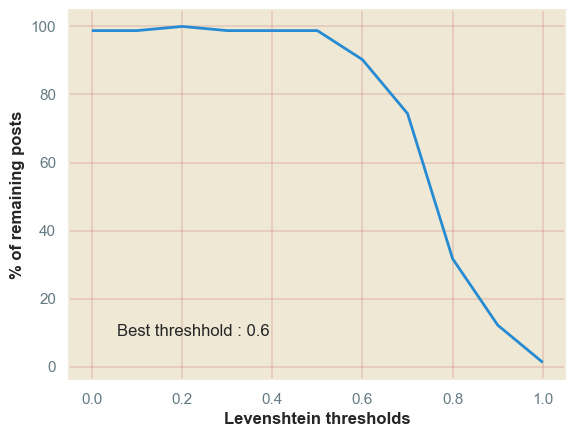

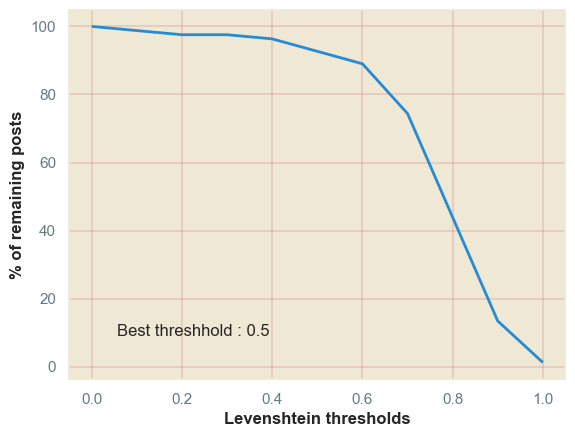

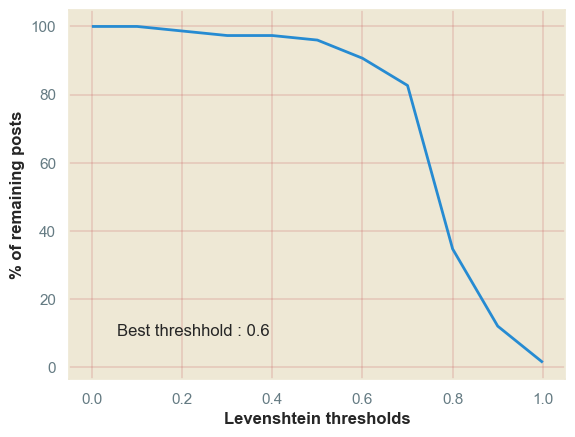

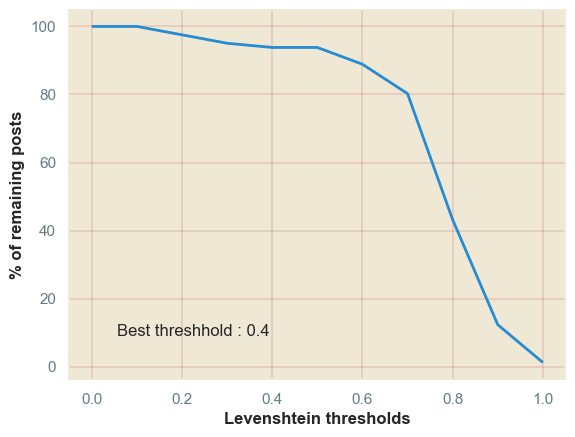

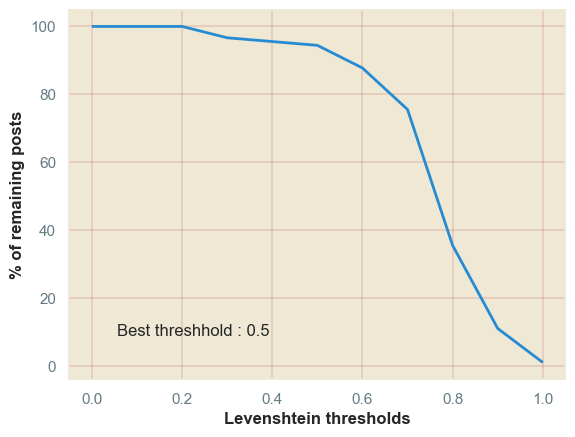

In [162]:
best_thresholds = plot_n_curves_remaining_posts(
                            n=20,
                            sample_size=100,
                            corpus=corpus)

In [ ]:
def get_duplicates(
    corpus: list, 
    limit: float, 
    method: callable
    ):
    originals = []
    copies = []
    t = [utilities.clean_hashtag(s).strip() for s in corpus]
    distance = method #initialisiation de levenshtein avec la distance normalisée.
    i = 0
    r = len(t)
    while(i<r):
        r = len(t)
        j=i+1
        while(j<r):
            if(distance(t[i],t[j]) <= limit ): # Si la distance entre les deux élemens de la liste inf à seuil
                originals.append(t[i])
                copies.append([t[j]])
                break
            j+=1
        i+=1
    return pd.DataFrame({'originals' : originals , 'copies' : copies})

In [ ]:
dist = textdistance.levenshtein.normalized_distance
originlas_copies = get_duplicates(corpus['text'].sample(n= 50, random_state = 42).tolist(),0.6,dist)

In [ ]:
corpus_test.to_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/test_levenshtein.csv")

In [ ]:
originlas_copies

In [ ]:
def get_duplicates_per_thresholds():
    list_duplicates_per_thresholds = []
    list_thresholds = np.linspace(0.4,1,13)
    dist = textdistance.levenshtein.normalized_distance
    for thresholds in list_thresholds:
        list_duplicates_per_thresholds.append(get_duplicates(corpus['text'].sample(n= 50, random_state = 10).tolist(),thresholds,dist))
    return pd.DataFrame({'threshold' : list_thresholds , 'duplicates' : list_duplicates_per_thresholds})

In [ ]:
df_dup_per_thesh = get_duplicates_per_thresholds()

In [ ]:
df_dup_per_thesh

In [ ]:
df_dup_per_thesh['duplicates'][4]

### Optimisation paramètres de l'arbre de décision

In [14]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/DATA/chanel_junk_valid_2.xlsx')
chanel_junk_valid_new = chanel_junk_valid_new[['text','is_junk']].dropna()
chanel_junk_valid_new['has_URL'] = utilities.get_presence_of_URL(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['has_phone_number'] = utilities.get_presence_of_phone_numbers(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['has_currency_symbol'] = utilities.get_presence_of_currency_symbol(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['word_ratio'] = utilities.get_word_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['caps_ratio'] = utilities.get_caps_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp)
chanel_junk_valid_new['norm_punct'] = utilities.get_normalized_nb_punct(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'emoji',nlp = nlp, top= 3))
chanel_all_features = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'hashtag', nlp = nlp, top= 3))
X_train, X_test, y_train, y_test = train_test_split(chanel_all_features.dropna().drop(['text','is_junk'],axis=1), chanel_all_features.dropna()['is_junk'], test_size=0.2, random_state=42)

Arbre 1 : 

In [ ]:
tree1 = DecisionTreeClassifier(criterion = 'gini')
tree1.fit(X_train,y_train)
y_pred = tree1.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 2

In [ ]:
tree2 = DecisionTreeClassifier(criterion = 'entropy')
tree2.fit(X_train,y_train)
y_pred = tree2.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 3

In [ ]:
tree3 = DecisionTreeClassifier(criterion = 'entropy',class_weight = "balanced")
tree3.fit(X_train,y_train)
y_pred = tree3.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 4

In [ ]:
tree4 = DecisionTreeClassifier(criterion = 'entropy', max_depth=10)
tree4.fit(X_train,y_train)
y_pred = tree4.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 5

In [ ]:
tree5 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 9, ccp_alpha =  0.001, min_samples_leaf = 5, max_features = 11, min_samples_split = 5, random_state = 42)
tree5.fit(X_train,y_train)
y_pred = tree5.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")
print(f"Precision : {confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[1][1]+confusion_matrix(y_test, y_pred)[1][0])}\nRecall    : {confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[1][1]+confusion_matrix(y_test, y_pred)[0][1])}")


### Combinaison des trois paramètres 

Gridsearch

In [38]:
param_grid = {  'criterion': ['entropy'],
                'ccp_alpha' : np.linspace(0,0.5,50),
                'min_samples_leaf' : np.linspace(2,15,14,dtype= int),
                'min_samples_split' : np.linspace(5,25,21,dtype= int)
                }  
   
grid = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid, scoring = 'roc_auc' ,refit = True, verbose = 3,n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 14700 candidates, totalling 73500 fits
{'ccp_alpha': 0.0, 'criterion': 'entropy', 'min_samples_leaf': 4, 'min_samples_split': 20}


Optimisaiton ccp

In [40]:
param_grid_ccp = {  'criterion': ['entropy'],
                    'ccp_alpha' : np.linspace(0.0,0.01,40),
                    'min_samples_leaf' : np.linspace(3,5,3,dtype= int),
                    'min_samples_split' : np.linspace(19,21,3,dtype= int)
                    }  

   
grid_ccp = GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid_ccp, scoring = 'precision' ,refit = True, verbose = 3,n_jobs=-1)
grid_ccp.fit(X_train, y_train)
print(grid_ccp.best_params_)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
{'ccp_alpha': 0.0071794871794871795, 'criterion': 'entropy', 'min_samples_leaf': 4, 'min_samples_split': 20}


Final tree

AUC : 0.667
Accuracy score : 0.730
Precision score : 0.647
Recall score : 0.344


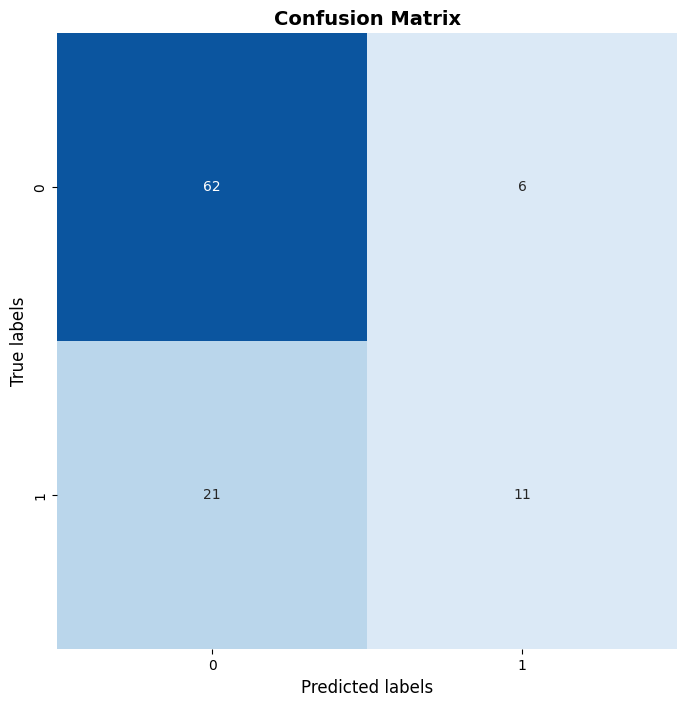

In [41]:
best_params = grid_ccp.best_params_
best_params['random_state']=42
tree_f = DecisionTreeClassifier(**best_params)
tree_f.fit(X_train,y_train)
y_pred = tree_f.predict(X_test)
utilities.evaluate(y_test=y_test,
                   y_pred=y_pred,
                   y_score=tree_f.predict_proba(X_test)[:, 1])

In [42]:
with open('C:/Users/a.tekiouk/Sujet_2/Models/model_tree_auc_spacy.pkl', 'wb') as f:  # open a text file
    pickle.dump(tree_f, f) # serialize the model

Affichage arbre

In [ ]:
sklearn.tree.plot_tree(tree_f,feature_names = X_train.columns, class_names = ['not junk','junk'], filled = True)

ROC

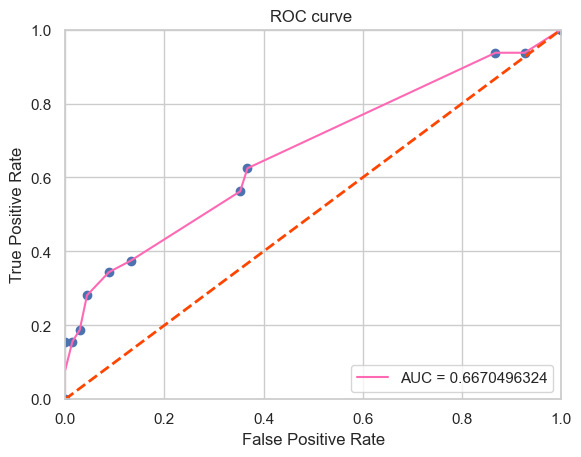

In [44]:
y_score = tree_f.predict_proba(X_test)[:,1]
utilities.plot_roc(y_test,y_score)